# Load the Dataset

In [243]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Correlation
from scipy.stats import chi2_contingency
import seaborn as sns

# PCA
from sklearn.decomposition import PCA

# KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score 

# KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

In [244]:
outfield_df = pd.read_csv("transformed_data/outfield_per90.csv")

# Preprocessing

In [245]:
print(f"Number of outfield player records before dropping duplicates: {len(outfield_df)}")
outfield_df = outfield_df.drop_duplicates()
print(f"Number of outfield player records after dropping duplicates: {len(outfield_df)}")

Number of outfield player records before dropping duplicates: 3958
Number of outfield player records after dropping duplicates: 3958


Visualising and dropping rows where with players that didn't play enough for sample to be representative

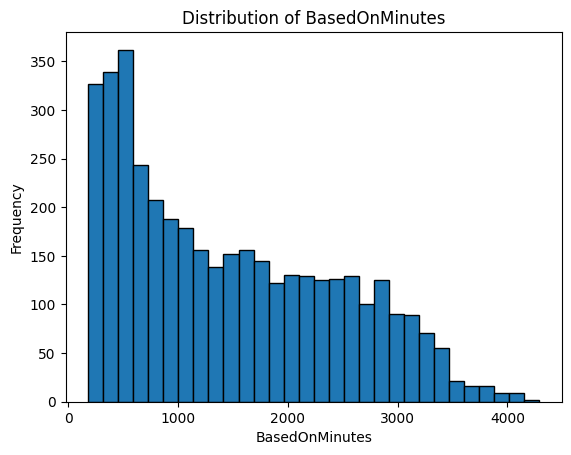

In [246]:
plt.hist(outfield_df['BasedOnMinutes'].dropna(), bins=30, edgecolor='k')
plt.xlabel('BasedOnMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of BasedOnMinutes')
plt.show()

In [247]:
# Dropping all entries with BasedOnMinutes less than 450 min, playing less than 5 games
print(f"Number of outfield outfield records before filtering: {len(outfield_df)}")
outfield_df = outfield_df[outfield_df['BasedOnMinutes'] >= 450]
print(f"Number of outfield outfield records after filtering: {len(outfield_df)}")

Number of outfield outfield records before filtering: 3958
Number of outfield outfield records after filtering: 3323


Dropping rows with "Last 365 Days Men's Big 5 Leagues"

In [248]:
# Drop rows where scouting_period is "Last 365 Days Men's Big 5 Leagues"
outfield_df = outfield_df[outfield_df['scouting_period'] != "Last 365 Days Men's Big 5 Leagues"]

Dropping per 90 data (not needed any more since split dataset into per90 and percentile, also hard to average percentile)

In [249]:
# # drop per90

# # Initial number of columns
# initial_column_count = outfield_df.shape[1]

# # Drop columns with "Per90" in their name
# columns_to_drop = [col for col in outfield_df.columns if 'Per90' in col]
# outfield_df = outfield_df.drop(columns=columns_to_drop)

# # Final number of columns
# final_column_count = outfield_df.shape[1]
# columns_dropped = initial_column_count - final_column_count

# print(f"Number of columns before dropping 'Per90': {initial_column_count}")
# print(f"Number of columns after dropping 'Per90': {final_column_count}")
# print(f"Number of columns dropped: {columns_dropped}")

Dropping Percentile data 

In [250]:
print(f"Number of outfield player records before dropping Percentile: {outfield_df.shape[1]}")
columns_to_drop = [col for col in outfield_df.columns if 'Percentile' in col]
outfield_df = outfield_df.drop(columns=columns_to_drop)
print(f"Number of outfield player records after dropping Percentile: {outfield_df.shape[1]}")

Number of outfield player records before dropping Percentile: 121
Number of outfield player records after dropping Percentile: 121


Handling na values

In [251]:
null_rows = outfield_df[outfield_df.isnull().any(axis=1)]
null_rows.to_excel('transformed_data/null_rows.xlsx', index=False)

In [252]:
# na_columns_goal_related = ['Percentile_Goals/Shot on Target', 
#                            'Percentile_npxG/Shot', 
#                            'Percentile_Average Shot Distance', 
#                            'Percentile_Goals/Shot', 
#                            'Percentile_Shots on Target %']
# na_columns_dribble_related = ['Percentile_Successful Take-On %',
#                               'Percentile_Tackled During Take-On Percentage']
# na_columns_others = ['Percentile_% of Dribblers Tackled',
#                      'Percentile_% of Aerials Won',
#                      'Percentile_Pass Completion % (Long)']
# # Fill missing values with 0 as corresponding player is not involved in those actions, suggesting they are not good at it.
# outfield_df[na_columns_goal_related] = outfield_df[na_columns_goal_related].fillna(0)
# outfield_df[na_columns_dribble_related] = outfield_df[na_columns_dribble_related].fillna(0)
# outfield_df[na_columns_others] = outfield_df[na_columns_others].fillna(0)

In [253]:
# If Per90 is not dropped
na_columns_goal_related_per90 = ['Per90_Goals/Shot on Target', 
                                 'Per90_npxG/Shot', 
                                 'Per90_Average Shot Distance', 
                                 'Per90_Goals/Shot', 
                                 'Per90_Shots on Target %']
na_columns_dribble_related_per90 = ['Per90_Successful Take-On %',
                                    'Per90_Tackled During Take-On Percentage']
na_columns_others = ['Per90_% of Dribblers Tackled',
                                    'Per90_% of Aerials Won',
                                    'Per90_Pass Completion % (Long)']
outfield_df[na_columns_goal_related_per90] = outfield_df[na_columns_goal_related_per90].fillna(0)
outfield_df[na_columns_dribble_related_per90] = outfield_df[na_columns_dribble_related_per90].fillna(0)
outfield_df[na_columns_others] = outfield_df[na_columns_others].fillna(0)

In [254]:
print(f"Number of rows with na values: {len(outfield_df[outfield_df.isnull().any(axis=1)])}")

Number of rows with na values: 0


Feature Scaling (Z-score, min-max, maxAbs etc.)

Feature Engineering

In [255]:
# Compute the Goals per Expected Goals Ratio
outfield_df["Finishing_Efficiency"] = outfield_df["Per90_Goals"] / outfield_df["Per90_Goals - xG"]

# Handle cases where xG is zero (avoid division by zero)
outfield_df["Finishing_Efficiency"].fillna(0, inplace=True)
outfield_df["Finishing_Efficiency"] = outfield_df["Finishing_Efficiency"].replace(np.inf, 0)

# Drop Per90_Goals - xG
outfield_df = outfield_df.drop(columns=["Per90_Goals - xG"])

# Compute the Assists per Expected Assists Ratio
outfield_df["Assist_Efficiency"] = outfield_df["Per90_Assists"] / outfield_df["Per90_xA: Expected Assists"]
outfield_df["Assist_Efficiency"].fillna(0, inplace=True)
outfield_df["Assist_Efficiency"] = outfield_df["Assist_Efficiency"].replace(np.inf, 0)
outfield_df = outfield_df.drop(columns=["Per90_xA: Expected Assists"])

/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_21378/1821035503.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  outfield_df["Finishing_Efficiency"].fillna(0, inplace=True)
/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_21378/1821035503.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

Combining rows to ensure that one entry is tagged to only one unique player

In [256]:
print(outfield_df.dtypes)

Player                             object
Versus                             object
BasedOnMinutes                      int64
scouting_period                    object
Per90_% of Aerials Won            float64
                                   ...   
Per90_npxG: Non-Penalty xG        float64
Per90_xAG: Exp. Assisted Goals    float64
Per90_xG: Expected Goals          float64
Finishing_Efficiency              float64
Assist_Efficiency                 float64
Length: 121, dtype: object


In [257]:
# Drop non-numeric column "scouting_period"
outfield_df = outfield_df.drop(columns=["scouting_period"], errors="ignore")

# Define numeric columns excluding categorical ones
numeric_cols = [col for col in outfield_df.columns if col not in ['Player', 'Versus', 'BasedOnMinutes']]

# Compute weighted averages for numeric stats
weighted_avg_df = outfield_df.groupby("Player").apply(
    lambda group: pd.Series(
        {col: np.average(group[col], weights=group["BasedOnMinutes"]) for col in numeric_cols}
    )
).reset_index()

# Drop "BasedOnMinutes" since it's no longer needed
outfield_df = weighted_avg_df.drop(columns=["BasedOnMinutes"], errors="ignore")

outfield_df.head()


/var/folders/73/wcqzpl9901z1403_p0wsmlsw0000gn/T/ipykernel_21378/1519352785.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_avg_df = outfield_df.groupby("Player").apply(


,Player,Per90_% of Aerials Won,Per90_% of Dribblers Tackled,Per90_Aerials Lost,Per90_Aerials Won,Per90_Assists,Per90_Average Shot Distance,Per90_Ball Recoveries,Per90_Blocks,Per90_Carries,...,Per90_Touches (Live-Ball),Per90_Touches (Mid 3rd),Per90_Yellow Cards,Per90_npxG + xAG,Per90_npxG/Shot,Per90_npxG: Non-Penalty xG,Per90_xAG: Exp. Assisted Goals,Per90_xG: Expected Goals,Finishing_Efficiency,Assist_Efficiency
0,Aaron Cresswell,53.744897,54.478054,1.050578,1.232776,0.126076,23.713051,5.019973,1.003463,33.071370,...,67.727667,31.363400,0.152007,0.151503,0.053259,0.028676,0.125962,0.028676,1.257216,1.235572
1,Aaron Wan-Bissaka,46.982567,74.928410,1.019510,0.916619,0.080330,15.204835,5.334216,1.442013,31.436534,...,66.273364,27.892252,0.126624,0.086534,0.081324,0.025679,0.061986,0.025679,0.752012,1.590200
2,Abdoulaye Doucouré,48.890342,34.887704,1.244611,1.177708,0.088108,16.691402,6.906970,1.076944,31.009267,...,54.856984,29.530726,0.222580,0.232226,0.115489,0.142039,0.088268,0.142039,-2.619657,1.300938
3,Abdul Fatawu Issahaku,57.046218,57.095822,1.323621,1.714821,0.390979,22.707866,5.051253,1.321935,34.739718,...,51.809492,16.360805,0.118291,0.484339,0.058513,0.145540,0.338799,0.145540,3.879055,1.239622
4,Adam Armstrong,36.222236,27.570076,0.875512,0.463434,0.162634,17.211408,2.588938,0.703846,21.511588,...,35.012507,12.474270,0.089829,0.474690,0.110658,0.345774,0.131012,0.410552,-10.361691,1.613350


Finding correlation between features 

In [258]:
# Function to compute Cramér's V
def cramers_v(cat_variable, num_variable):
    contingency_table = pd.crosstab(outfield_df[cat_variable], pd.qcut(outfield_df[num_variable], q=4))
    chi2 = chi2_contingency(contingency_table)[0]
    n = outfield_df.shape[0]
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Identify categorical and numerical columns
categorical_cols = []
non_numeric_cols = ["Player"] + categorical_cols
numerical_cols = outfield_df.select_dtypes(include=["float64", "int64"]).columns

# Drop non-numeric variables before computing numerical correlations
numerical_df = outfield_df.drop(columns=non_numeric_cols, errors="ignore")

# Compute Pearson correlation for numerical variables
numerical_corr_matrix = numerical_df.corr()

# Initialize Cramér’s V matrix for categorical-numerical correlations
cramers_matrix = pd.DataFrame(index=categorical_cols, columns=numerical_cols)

# Compute Cramér's V for categorical-numerical relationships
for cat_col in categorical_cols:
    for num_col in numerical_cols:
        if cat_col != num_col:
            cramers_matrix.loc[cat_col, num_col] = cramers_v(cat_col, num_col)

# Convert Cramér’s V values to float
cramers_matrix = cramers_matrix.astype(float)

# Merge Pearson correlation with Cramér’s V correlation
full_correlation_matrix = numerical_corr_matrix.copy()

for cat_col in categorical_cols:
    for num_col in numerical_cols:
        full_correlation_matrix.loc[cat_col, num_col] = cramers_matrix.loc[cat_col, num_col]

# Convert final matrix to float for heatmap
full_correlation_matrix = full_correlation_matrix.astype(float)


In [259]:
# Set correlation threshold 
correlation_threshold = 0.9

# Compute the absolute correlation matrix
corr_matrix = full_correlation_matrix.abs()

# Create a set to hold the features to remove
features_to_remove = set()

# Iterate through correlation matrix and identify features to drop
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > correlation_threshold:  # If correlation is above threshold
            colname = corr_matrix.columns[i]  # Get feature name
            features_to_remove.add(colname)  # Add it to the removal list

# Drop the identified features
outfield_df_reduced = outfield_df.drop(columns=features_to_remove, errors="ignore")

# Save the cleaned dataset
outfield_df_reduced.to_csv("transformed_data/outfield_stats_cleaned.csv", index=False)

print(f"Removed {len(features_to_remove)} highly correlated features.")
print(f"Remaining features: {outfield_df_reduced.shape[1]}")

Removed 37 highly correlated features.
Remaining features: 81


Reducing Dimension

Number of features before PCA: 117
Number of features after PCA: 36


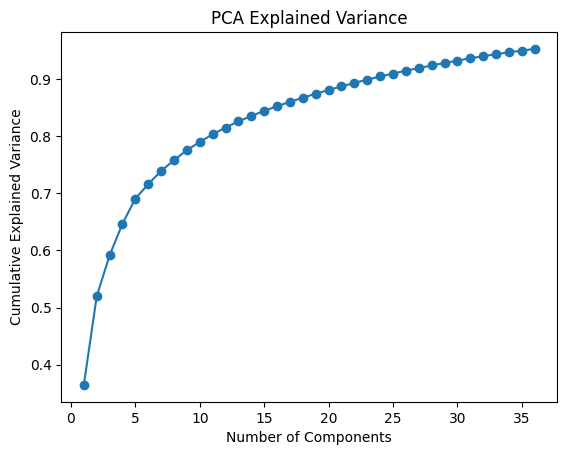

In [260]:
# Specify categorical columns to keep
non_statistical_data = ["Player"]  

# Separate categorical and numerical features
kept_features_df = outfield_df[non_statistical_data].reset_index(drop=True)  # Reset index for safe merge
features = outfield_df.drop(columns=non_statistical_data)  # Drop categorical columns for PCA

# Print the number of features before PCA
print("Number of features before PCA:", features.shape[1])

# Standardize numerical features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA output back to DataFrame
pca_df = pd.DataFrame(X_pca, index=outfield_df.index)

# Name PCA columns properly
pca_df.columns = [f'PCA_{i+1}' for i in range(pca_df.shape[1])]

# Concatenate categorical columns with PCA-transformed numerical data
outfield_df_pca = pd.concat([kept_features_df, pca_df.reset_index(drop=True)], axis=1)

# Print the number of features after PCA
print("Number of features after PCA:", pca_df.shape[1])

# Plot PCA explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title("PCA Explained Variance")
plt.show()

Encoding Categorical Variables (all categorical were dropped as we are manually separating by position)

In [261]:
# print("Columns before encoding:", outfield_df.columns)
# outfield_df = pd.get_dummies(outfield_df, columns=['Versus', 'scouting_period'])
# print("Columns after encoding:", outfield_df.columns)

Others (Removing outliers)

# Clustering

## K Means

Custom Initial Cluster Centers:
 [[-0.83228853 -0.87247311  0.5642536  -0.17429018  0.63513893 -0.24269883
  -0.92372453 -0.64274234 -0.79544046  0.44785244  1.04216996 -0.1965841
  -0.82355517 -0.07820218  0.08176828  0.02965527 -0.63195423  0.96098139
  -0.83807865 -0.58405418 -0.64759693  0.17639425  0.53744164 -0.21204461
   0.23604494  0.74378611  0.53088403  0.73495711  0.88424741  0.7479002
   1.09779393  1.07400255  0.63692364  0.43153831 -0.04709992 -1.04807549
   0.49738385 -1.06509782  1.13959185  1.12606207  0.16491209  1.10143473
  -0.17800296 -0.27385794 -0.86589761 -0.22616669 -0.91732371 -0.9363004
  -1.11021473 -0.99106553 -1.08455657 -0.83978826  0.18266121 -1.08455499
  -0.98392461 -1.05209372 -0.86816039 -0.25085794 -0.79586445 -0.98064736
  -1.00655842  0.32107514  0.54505979 -0.56315484  0.51814791  0.76585004
   0.73260298 -0.30948158 -0.754818    1.0266678  -1.0810996  -0.14065715
  -0.20186009  0.14193222  0.86495824  0.47716631  1.03219133  0.99507838
  -0.107

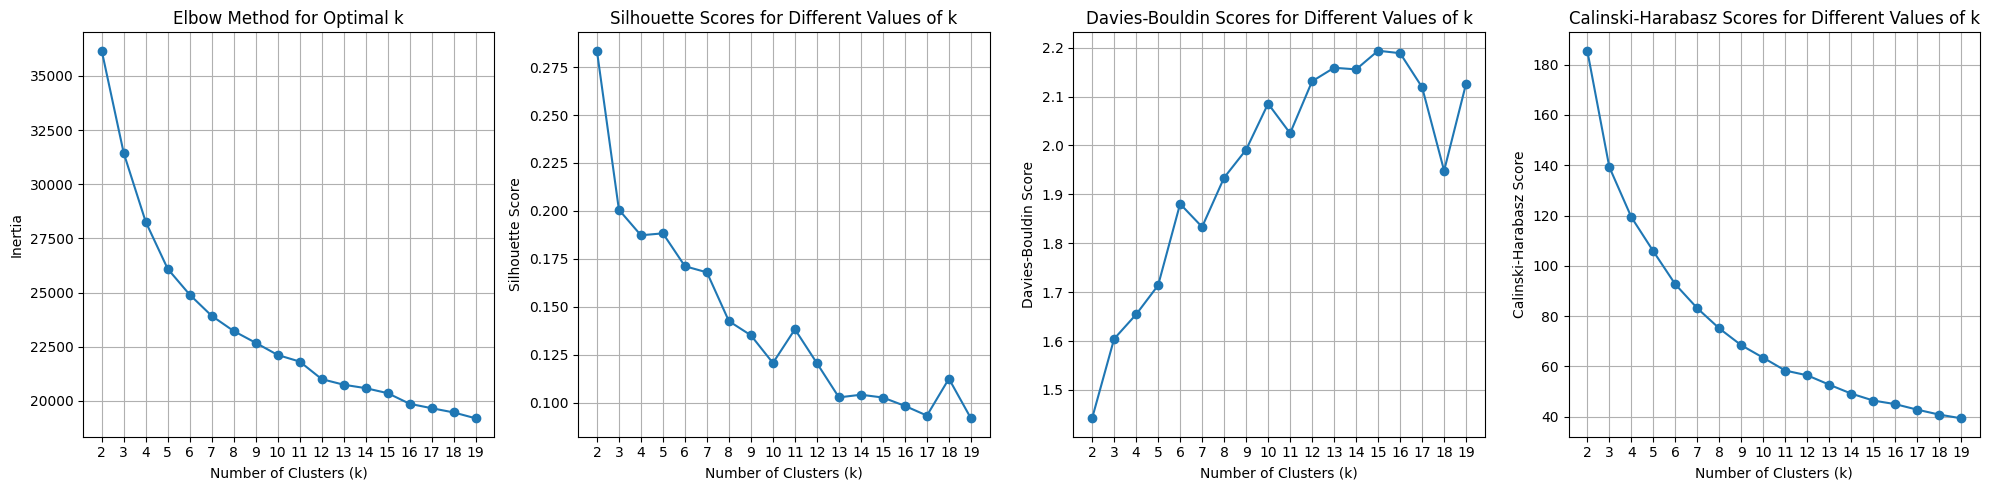

Best k according to Elbow Method: 11
Best k according to Silhouette Score: 2
Best k according to Davies-Bouldin Score: 2
Best k according to Calinski-Harabasz Score: 2


In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Select features for clustering (exclude categorical columns)
features = outfield_df.drop(columns=['Player'])

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Ensure selected players exist before computing centroids
selected_players = ["Kevin De Bruyne", "Virgil van Dijk", "Erling Haaland"]
existing_players = outfield_df[outfield_df["Player"].isin(selected_players)].copy()

if len(existing_players) < len(selected_players):
    print(f"Warning: Not all selected players exist in dataset! Found {len(existing_players)}.")

# Drop categorical columns from existing players
numeric_features = existing_players.drop(columns=['Player' ])

# Standardize existing player stats **before computing centroids**
scaled_existing_players = scaler.transform(numeric_features)

# Compute centroid values for known archetypes
centroids = np.array(scaled_existing_players)

# Fit KMeans using expert-chosen centroids
k_means = KMeans(n_clusters=centroids.shape[0], init=centroids, n_init=1, random_state=42)
k_means.fit(scaled_features)

# Get cluster labels
labels = k_means.labels_
print("Custom Initial Cluster Centers:\n", k_means.cluster_centers_)

# Range of k values to try
k_values = range(2, 20)
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Loop through different values of k
for k in k_values:
    k_means = KMeans(n_clusters=k, random_state=42, n_init=10, init='k-means++')
    k_means.fit(scaled_features)
    labels = k_means.labels_
    
    inertia.append(k_means.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, labels))
    davies_bouldin_scores.append(davies_bouldin_score(scaled_features, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(scaled_features, labels))

# Plot the evaluation metrics
plt.figure(figsize=(20, 5))

# Plot the inertia values (Elbow Method)
plt.subplot(1, 4, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

# Plot the silhouette scores
plt.subplot(1, 4, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

# Plot the Davies-Bouldin scores
plt.subplot(1, 4, 3)
plt.plot(k_values, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(k_values)
plt.grid(True)

# Plot the Calinski-Harabasz scores
plt.subplot(1, 4, 4)
plt.plot(k_values, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

# Function to find the elbow point
def find_elbow_point(inertia):
    diff = np.diff(inertia)
    diff_r = diff[1:] / diff[:-1]
    elbow_point = np.argmin(diff_r) + 2  # +2 because diff reduces the length by 1 and we start from k=2
    return elbow_point

# Find the best k for each metric
best_k_elbow = find_elbow_point(inertia)
best_k_silhouette = k_values[np.argmax(silhouette_scores)]
best_k_davies_bouldin = k_values[np.argmin(davies_bouldin_scores)]
best_k_calinski_harabasz = k_values[np.argmax(calinski_harabasz_scores)]

print(f"Best k according to Elbow Method: {best_k_elbow}")
print(f"Best k according to Silhouette Score: {best_k_silhouette}")
print(f"Best k according to Davies-Bouldin Score: {best_k_davies_bouldin}")
print(f"Best k according to Calinski-Harabasz Score: {best_k_calinski_harabasz}")

# Classification

## KNN

In [265]:
# Manually specify certain players and their archetypes
player_archetypes = {
    'Trent Alexander-Arnold' : 'Wing Back'
}

# Add a new column for archetypes and label the specified players
outfield_df['Archetype'] = outfield_df['Player'].map(player_archetypes)

# Separate the labeled and un_labelled data
labeled_data = outfield_df.dropna(subset=['Archetype']).copy()
un_labelled_data = outfield_df[outfield_df['Archetype'].isna()].copy()

# continue...